## Get a frame stream from a merlin detector

If you want to use this with the simulated data source, run something like this in the background:

`libertem-live-mib-sim ~/Data/default.hdr --cached=MEM --wait-trigger`

The `--wait-trigger` option is important for this notebook to function correctly since that allows to drain the data socket before an acquisition like it is necessary for a real-world Merlin detector.

A suitable MIB dataset can be downloaded at https://zenodo.org/record/5113449.

On Linux, `MEMFD` is also supported as a cache. Use `NONE` to deactivate the cache.

In [1]:
# set this to the host/port where the merlin data server is listening:
MERLIN_DATA_SOCKET = ('127.0.0.1', 6342)
MERLIN_CONTROL_SOCKET = ('127.0.0.1', 6341)

In [2]:
%matplotlib nbagg

In [3]:
import time
import logging
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from libertem_live.detectors.merlin import MerlinDataSource
from libertem_live.detectors.merlin import MerlinControl
# Used here to emulate triggering and a blocking function that waits
# for a scan to finish
from libertem_live.detectors.merlin.sim import TriggerClient

In [5]:
data_source = MerlinDataSource(host=MERLIN_DATA_SOCKET[0], port=MERLIN_DATA_SOCKET[1], pool_size=3)
control = MerlinControl(host=MERLIN_CONTROL_SOCKET[0], port=MERLIN_CONTROL_SOCKET[1])

In [6]:
result = np.zeros((256, 256), dtype=np.float32)
result_nav = np.zeros(128*128, dtype=np.float32)

In [7]:
with control:  # This connects the control socket
    # Here go Merlin control commands
    with data_source:  # This connects the data socket
        data_source.socket.drain()
        control.cmd('STARTACQUISITION')
        control.cmd('SOFTTRIGGER')
        index = 0
        for frames in data_source.stream(num_frames=128*128, chunk_size=128):
            result += frames.buf.sum(axis=0)
            real_size = frames.buf.shape[0]
            result_nav[index:index+real_size] = frames.buf.sum(axis=(1, 2))
            index += real_size

<IPython.core.display.Javascript object>


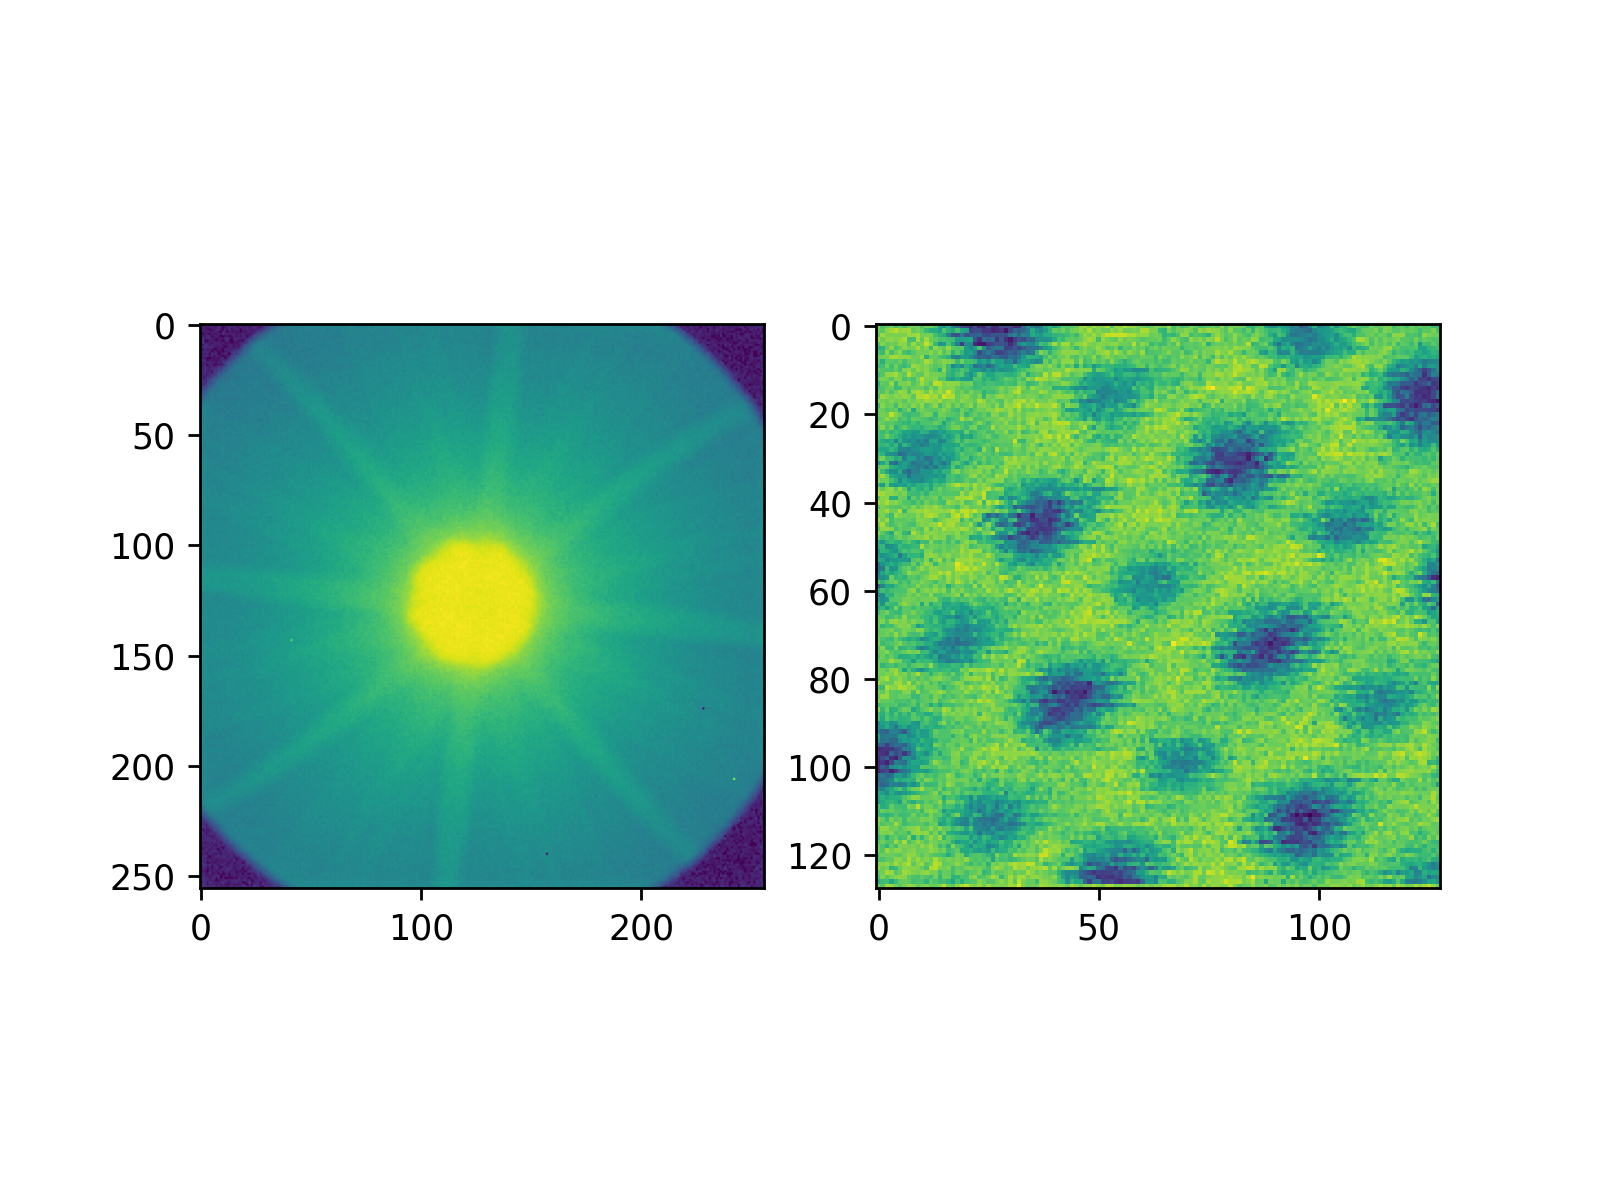

In [8]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.log1p(result))
axes[1].imshow(np.log1p(result_nav.reshape((128, 128))))